# Problem 0: Backoff language model (30%)

# Shunli Lu Boning Huang Huizhi Li

### We know that having unknown words in text is a problem for a language model. Any estimate of probability is difficult in such a scenario. 

### In class, we saw a simple way of smoothing probabilities by adding count 1 to every occuring ngram. While this can be a simple and effective technique we can do something a bit more clever. In this exercise we will implement two such techniques. 

### 1) to deal with unknown unigrams we will introduce a special `<unk>` token in our training data to represent rare tokens

### 2) for unknown bigrams we will use a technique called backoff. The idea is to "backoff" to a lower order n-gram estimate for the probability if the n-gram is unknown. For example the probability of an unknown bigram `w_1 w_2` can be estimated by looking at the unigram probability of `w_2`. 

In [197]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\shunl\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [198]:
import pandas as pd
import numpy as np
import re
from collections import Counter

wiki_df = pd.read_csv('./data/kdwd_r1k_articles.csv')

def get_tokens(text):
    return ['<s>'] + re.findall(r'\w+', text.lower()) + ['</s>']

train_sentences_list = ' '.join(wiki_df['intro_text'].iloc[:-100].tolist()).split('.')
test_sentences_list = ' '.join(wiki_df['intro_text'].iloc[-100:].tolist()).split('.')

### First, let's build a basic 1-gram language model

In [199]:
train_token_list = [get_tokens(text) for text in train_sentences_list]

In [200]:
train_token_list = [item for sublist in train_token_list for item in sublist]
unigram_counts = Counter()
# your code here
for word in train_token_list:
    unigram_counts[word] += 1
n_unigrams = np.sum([v for _, v in unigram_counts.items()])

In [201]:
assert(n_unigrams == 95491)

In [202]:
def get_unigram_token_prob(token):
    return unigram_counts[token] / n_unigrams

def get_text_prob_unigram(text):
    tokens = get_tokens(text)
    logp = 0
    for t in tokens:
        # code here
        logp += np.log(get_unigram_token_prob(t))
    return np.exp(logp)

In [203]:
assert(get_unigram_token_prob('apple').round(5) == 0.00046)
assert(get_text_prob_unigram('the company').round(9) == 2.455e-06)

### Note that we haven't yet introduced any smoothing, meaning, out-of-vocabulary words will have a probability of 0:

In [204]:
get_text_prob_unigram("onomatopoeia")

C:\Users\shunl\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


0.0

### We have learned that we can simply add 1 to every word count to prevent this (ref: laplace smoothing). Another way however is to mark rare words within our training set as unknown words. The idea is that the model will then learn how to deal with unknown/rare words, to more correctly evaluate a test text.

### For this, let us first identify all unigrams that occur fewer or equal than k times. Let's use k=1 to start out with.

In [205]:
rare_tokens = set()
# you loop code here
k = 1
for token in train_token_list:
    if unigram_counts[token] <= k:
        rare_tokens.add(token)

In [206]:
assert(len(rare_tokens) == 4859)

### Next, let's create a new counter `filtered_unigram_counts` where every token that appears in `rare_tokens` is recorded as the special token `<unk>`

In [207]:
filtered_unigram_counts = Counter()
for token_list in train_token_list:
# your code here
    if token_list in rare_tokens:
        filtered_unigram_counts['<unk>'] += 1
    else:
        filtered_unigram_counts[token_list] += 1

n_filtered_unigrams = np.sum([v for _, v in filtered_unigram_counts.items()])

In [208]:
assert(filtered_unigram_counts['<unk>'] == 4859)

### To use these new counts, let's modify our text probability function

In [209]:
def get_filtered_unigram_token_prob(token):
    return filtered_unigram_counts[token] / n_filtered_unigrams

def get_text_prob_filtered_unigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]# get tokens and convert to <unk> if needed
    logp = 0
    for t in tokens:
        logp += np.log(get_filtered_unigram_token_prob(t))
    return np.exp(logp)

In [210]:
assert(get_filtered_unigram_token_prob('apple').round(5) == 0.00046)
assert(get_text_prob_filtered_unigram('the company').round(9) == 2.455e-06)
assert(get_text_prob_filtered_unigram("onomatopoeia").round(5) == 0.00016)

### We can see that now unknown words actually have a probability higher than some of the rare words that we have already seen before like `apple`.

### The choice of count 1 to label words as `<unk>`was arbitrary. How could we tune is if we had more time?

# your text answer here
We can change the setup of rare words. For instance, we can set a smaller value for k. In such a way, the probability should be more reasonable

### Let's expand our model to bigrams now. Make sure to check if each component in a bigram exists and label it as `<unk>` if needed.

In [211]:
filtered_bigram_counts = Counter()
for i in range(len(train_token_list)-1):
    # your loop and 'unk' conversion here
    t1 = train_token_list[i] if train_token_list[i] not in rare_tokens else '<unk>'
    t2 = train_token_list[i+1] if train_token_list[i+1] not in rare_tokens else '<unk>'
    filtered_bigram_counts[t1 + ' ' + t2] += 1

def get_filtered_bigram_token_prob(token1, token2):
    return filtered_bigram_counts[token1 + ' ' + token2] / filtered_unigram_counts[token1]
        
def get_text_prob_filtered_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    logp = 0
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        logp += np.log(get_filtered_bigram_token_prob(t1, t2))
    return np.exp(logp)

In [212]:
assert(get_text_prob_filtered_bigram('the company').round(5) == 0.00148)

### We correctly get a higher probabiliy for `the company`, now that we are respecting bigrams.
### However:

In [213]:
get_text_prob_filtered_bigram('company the')

C:\Users\shunl\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


0.0

### We can see that we still get 0 for unknown bigrams. Let's fix this via Backoff. To reiterate: the idea is to default to unigram probabilities if the bigram is unknown.

In [214]:
def get_backoff_bigram_token_prob(token1, token2):
    # check if bigram exists and if not return unigram token2 prob 
    if token1 + ' ' + token2 in filtered_bigram_counts:
        return get_filtered_bigram_token_prob(token1, token2)
    else:
        return get_filtered_unigram_token_prob(token2)

In [215]:
def get_text_prob_backoff_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    logp = 0
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        logp += np.log(get_backoff_bigram_token_prob(t1, t2))
    return np.exp(logp)

In [216]:
assert(get_text_prob_backoff_bigram('company the').round(8) == 1.1e-07)

### We can happily now estimate any input text we can think of with running into issues with 0.

### Let's see if this was all worth it. Let's evaluate perplexity.
### Specifically compare the perplexity of our filtered unigram model `get_filtered_unigram_token_prob` to our new and improved backoff bigram model `get_backoff_bigram_token_prob`

### Note: For easy comparison let's only evaluate `tokens[1:]` for both models such that even the first token can already form a correct bigram

In [217]:
def get_text_ppl_filtered_unigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    # your code
    n_tokens = len(tokens)
    logp = 0
    for t in tokens[1:-1]:
        logp += np.log(get_filtered_unigram_token_prob(t))
    return (1 / np.exp(logp))**(1 / n_tokens)

def get_text_ppl_backoff_bigram(text):
    tokens = [token if token in filtered_unigram_counts else '<unk>' for token in get_tokens(text)]
    # your code
    n_tokens = len(tokens)
    logp = 0
    for t1, t2 in zip(tokens, tokens[1:-1]):
        logp += np.log(get_backoff_bigram_token_prob(t1, t2))
    return (1 / np.exp(logp))**(1 / n_tokens)

In [218]:
ppl_list = []
for text in test_sentences_list:
    ppl_list.append(get_text_ppl_filtered_unigram(text))
model_unigram_ppl = np.mean(ppl_list)

In [219]:
ppl_list = []
for text in test_sentences_list:
    ppl_list.append(get_text_ppl_backoff_bigram(text))
model_bigram_ppl = np.mean(ppl_list)

In [220]:
assert(model_bigram_ppl < model_unigram_ppl)

### Seems like it worked very well. Try to find one or two examples of short strings that clearly show that our bigram model is better and why. (Short answer is OK here)

In [ ]:
# your answer here

In [221]:
text = 'United States'

get_text_prob_backoff_bigram(text),get_text_prob_filtered_unigram(text)

(0.0004633571836538262, 5.395621085297207e-08)

In [222]:
text2 = 'States United'

get_text_prob_backoff_bigram(text2),get_text_prob_filtered_unigram(text2)

(2.6115189766940493e-07, 5.395621085297207e-08)

The string "United States" and its reverse clearly show that our bigram model is better since our bigram model takes order into consideration.

# Problem 1: Open-ended ML optimization (20%)

In [223]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


C:\Users\shunl\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## The moons dataset
Recall our moons dataset. Here we will see how well we can do with a decision tree on it. 

## Steps:
 - ### Generate the data
 - ### split it into 80/20 train/tess
 - ### Do a grid search to find the best parameters
 - ### Re-train with the best parameters
 - ### Evaluate performance on the test set (you should be able to get above 83% accuracy)

Text(0.5,1,'Fake Classification Data')

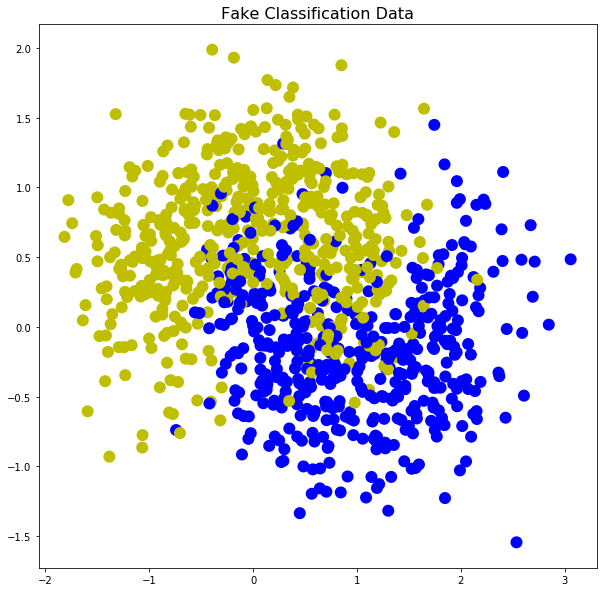

In [224]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
Xm, ym = make_moons(n_samples=50000, noise=0.4, random_state=53)

plt.figure(figsize=(10,10))
colors=['b' if y == 1 else 'y' for y in ym[:1000]]
plt.scatter(Xm[:1000, 0], Xm[:1000, 1], c=colors, linewidths=6)
plt.title('Fake Classification Data', fontsize=16)

In [225]:
# code goes here

In [226]:
from sklearn.model_selection import train_test_split
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, random_state=42)

In [227]:
# Do grid search to find best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(Xm_train, ym_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:   45.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, ve

In [228]:
y_pred = grid_search_cv.predict(Xm_test)
from sklearn.metrics import accuracy_score
accuracy_score(ym_test, y_pred)

0.8577

# Problem 2: The XOR Gate Revisted (20%)
## In this problem we'll explore the xor gate when we add noise to it and examine the decision boundary.

In [229]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(1234)

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


C:\Users\shunl\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 0: Generate data
 - ### Generate 2000 points of two dimensional random data (`X.shape` should be `(2000,2)`)
 - ### Compute `y_xor`

In [230]:
x = np.random.rand(2000, 2) > 0.5
y_xor = np.logical_xor(x[:, 0], x[:, 1])

## Part 1: Fit two classifiers
 - ### Partition the data into train and test
 - ### Fit both logistic regression and a single decision tree to the `x_or` data.
 - ### Compute the accuracy out of sample for each model
 - ### Make a plot of the decision boundary (NB see the class notes for help) and comment on what you see

In [231]:
# your code here
x_train, x_test, yxor_train, yxor_test = train_test_split(x, y_xor, test_size = 0.2, random_state = 42)
#Generate y_or
y_or = np.logical_or(x[:, 0], x[:, 1])
#Fit logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, yxor_train)
accuracy_score_log = accuracy_score(yxor_test, lr.predict(x_test))

#Fit single decision tree
dt1= DecisionTreeClassifier(max_depth = 1, random_state = 42)
dt1.fit(x_train, yxor_train)
accuracy_score_dt = accuracy_score(yxor_test, dt1.predict(x_test))
print("Accuracy Scores:" + "\n" + "Logistic Regression:" + str(accuracy_score_log) + "\n" + "Single Decision Tree:" + str(accuracy_score_dt))


Accuracy Scores:
Logistic Regression:0.205
Single Decision Tree:0.4675


In [232]:
def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", )
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", )
        plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

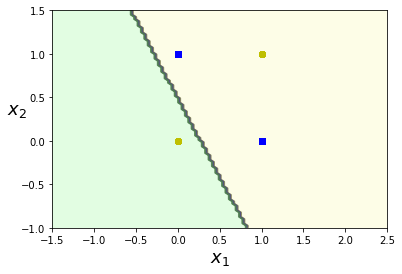

In [233]:
# your code here
# make some plots
#decision boundary for logistic regression
plot_decision_boundary(lr, x_test, yxor_test, axes=[-1.5, 2.5, -1, 1.5])

C:\Users\shunl\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


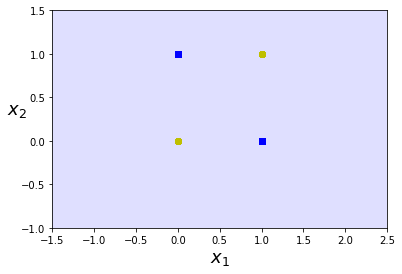

In [234]:
#decision boundary for decision tree
plot_decision_boundary(dt1, x_test, yxor_test, axes=[-1.5, 2.5, -1, 1.5])

In [181]:
# PUT COMMENTS HERE 
# The logistic regression clearly is limited in predicting this kind of data as it cannot slice well to include both points.
# The single decision tree model is more accurate than logistic regression model.

## Part 2: Add Noise
 - ### Add a small amount of random normal noise to both dimensions of X
 - ### Find what "small" is by plotting the data and making sure the clusters don't overlap
 - ### Repeat fitting both a decision tree and logistic regression to the data
 - ### Compute the out of sample accuracies.
 - ### Plot the decision boundaries and comment on the results

In [235]:
x_noisy = x + 0.05 * np.random.randn(x.shape[0], x.shape[1])

Text(0.5,1,'Check Clusters Do Not Overlap')

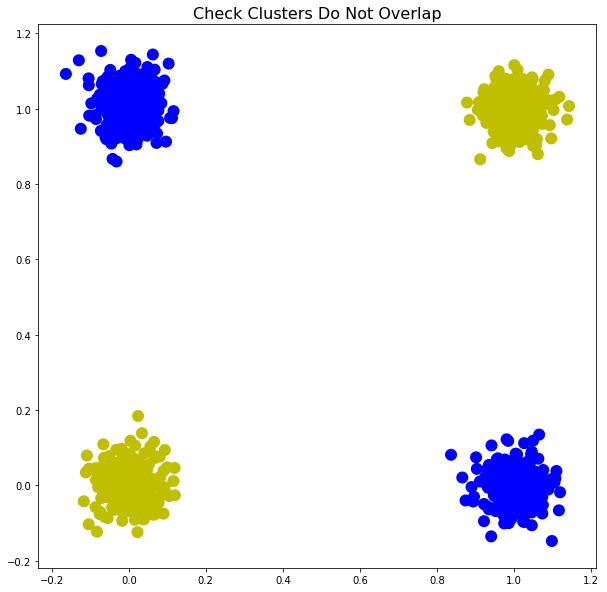

In [236]:
# your code here
# make some plots
plt.figure(figsize=(10,10))
colors=['b' if y == 1 else 'y' for y in y_xor[:1000]]
plt.scatter(x_noisy[:1000, 0], x_noisy[:1000, 1], c=colors, linewidths=6)
plt.title('Check Clusters Do Not Overlap', fontsize=16)

In [237]:
x_noisy_train, x_noisy_test, y_noisy_train, y_noisy_test = train_test_split(x_noisy, y_xor, test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(x_noisy_train, y_noisy_train)
accuracy_score_log = accuracy_score(y_noisy_test, lr.predict(x_noisy_test))

dt1= DecisionTreeClassifier(max_depth = 1, random_state = 42)
dt1.fit(x_noisy_train, y_noisy_train)
accuracy_score_dt = accuracy_score(y_noisy_test, dt1.predict(x_noisy_test))

print("Accuracy Scores:" + "\n" + "Logistic Regression:" + str(accuracy_score_log) + "\n" + "Single Decision Tree:" + str(accuracy_score_dt))


Accuracy Scores:
Logistic Regression:0.205
Single Decision Tree:0.4675


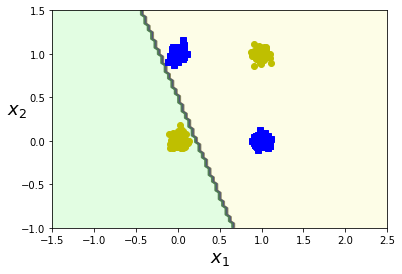

In [238]:
plot_decision_boundary(lr, x_noisy_test, y_noisy_test, axes=[-1.5, 2.5, -1, 1.5])

C:\Users\shunl\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


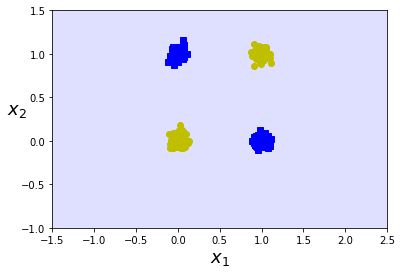

In [239]:
plot_decision_boundary(dt1, x_noisy_test, y_noisy_test, axes=[-1.5, 2.5, -1, 1.5])

In [10]:
# PUT COMMENTS HERE!
# Accuracy scores of both models are not much different from the ones in no-noise case.
# When clusters have noise but do not overlap, there is little difference from the no-noise scenario.

## Part 3: Add More Noise!
 - ### Add more noise to the point where the clusters slightly overlap
 - ### Fit THREE models: an unrestricted decision tree, a regularized tree, and logistic regression
 - ### Compute the out of sample accuracies.
 - ### Plot the decision boundaries and comment on the results

In [240]:
x_noisy = x + 0.25 * np.random.randn(x.shape[0], x.shape[1])
x_noisy_train, x_noisy_test, y_noisy_train, y_noisy_test = train_test_split(x_noisy, y_xor, test_size=0.2, random_state=42)

lr_noisy = LogisticRegression(C=1e3)
# add code here
lr_noisy.fit(x_noisy_train, y_noisy_train)
accuracy_score_log = accuracy_score(y_noisy_test, lr.predict(x_noisy_test))

dt_noisy = DecisionTreeClassifier()
# add code here
dt_noisy.fit(x_noisy_train, y_noisy_train)
accuracy_score_dt = accuracy_score(y_noisy_test, dt_noisy.predict(x_noisy_test))

# add more code for restricted tree
dt_noisy_restricted = DecisionTreeClassifier(min_samples_leaf=4)
dt_noisy_restricted.fit(x_noisy_train, y_noisy_train)
accuracy_score_dt_restricted = accuracy_score(y_noisy_test, dt_noisy_restricted.predict(x_noisy_test))

print("Accuracy Scores:" + "\n" + "Logistic Regression:" + str(accuracy_score_log) + "\n" + "Decision Tree Unrestricted:" + str(accuracy_score_dt) + "\n" + "Decision Tree Restricted:" + str(accuracy_score_dt_restricted))



Accuracy Scores:
Logistic Regression:0.315
Decision Tree Unrestricted:0.915
Decision Tree Restricted:0.9275


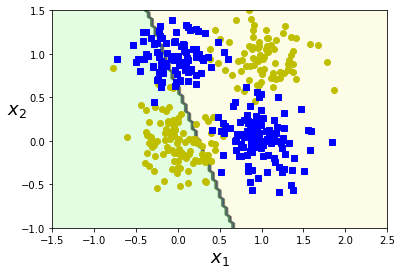

In [241]:
# plotting code here
#Logistic Regression
plot_decision_boundary(lr_noisy, x_noisy_test, y_noisy_test, axes=[-1.5, 2.5, -1, 1.5])

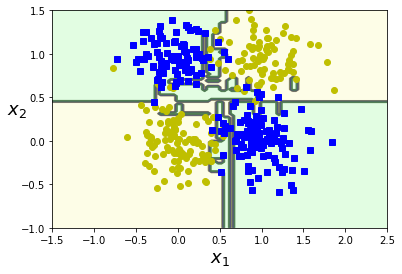

In [242]:
# Unrestricted Tree
plot_decision_boundary(dt_noisy, x_noisy_test, y_noisy_test, axes=[-1.5, 2.5, -1, 1.5])

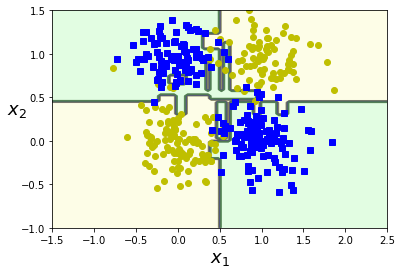

In [243]:
# Restricted Tree
plot_decision_boundary(dt_noisy_restricted, x_noisy_test, y_noisy_test, axes=[-1.5, 2.5, -1, 1.5])

In [196]:
# COMMENTS
# The advantage of decision tree models is more obvious when noise is heavy, as from the accuracy scores ---
# The accuracy scores of decision tree models are vastly higher than logistic regression's
# By restricting the minimum number of samples of each leaf, we get neater 'slicing' at small cost on accuracy


# Problem 3: The limits of trees and ensembles (30%)
## In this problem we will look at the limits of trees and ensembles compared to other methods. Specifically, we will investigate how they extrapolate vs interpolate

In [245]:
import numpy as np
import pandas as pd
%pylab inline

np.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


C:\Users\shunl\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part 0: generate some timeseries data of the form $y=c_0 x + c_1 \cos(\omega x) + \epsilon$
### where $\epsilon$ is noise

### TODO
 - ### Generate the data
 - ### Partition the data randomly into train and test
 - ### Plot the data, with train and test as different colors

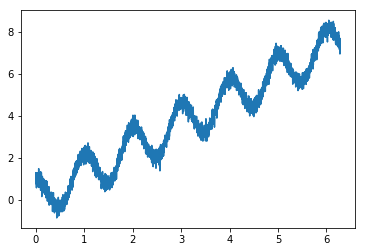

In [246]:
num_points = 4096
coef = 1.2
omega = 2 * np.pi
noise_ampl = 0.2

x_vals = np.linspace(0, 2 * pi, num_points)
y_vals = np.cos(omega * x_vals) + coef * x_vals + noise_ampl * np.random.normal(size=(x_vals.shape[0],))
pd.Series(y_vals, index=x_vals).plot()

In [320]:
#your code here for 60/40 train/test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_vals,y_vals,test_size=0.4)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)


assert x_train.shape[0] == 2457, "something went wrong"

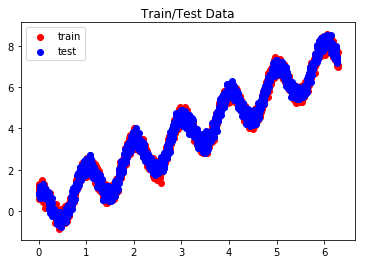

In [321]:
# plotting code here
plt.scatter(x_train, y_train,label='train', c='r')
plt.scatter(x_test, y_test, label='test', c='b')
plt.title('Train/Test Data')
plt.legend()

## Part 2: Evaluate some estimators
In this part we'll use mean squared error on the test set as a metric. 

 - ### For a bunch of different estimators, 
   - evaluate the test set MSE
   - plot both `y_test` and the predicted value for `x_test` as a function of `x_test`, in different colors
 - ### Use 
   - decision trees of depths 2, 4, 6, 8, 10, 12, 14, 16
   - linear regression
 - ### Additionally, 
   - calculate and print the MSE for a constant guess based on the train set
   - calculate and print the MSE for a constant guess based on the test set


In [322]:
# some helpful imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

(0.5081569375240118, 5.850628661780787, 5.921706431710938)

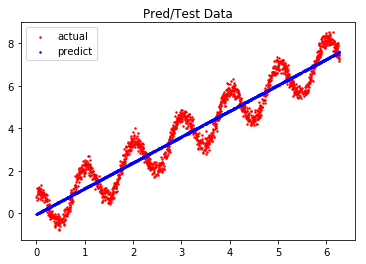

In [323]:
# your code here for evaluating estimators

reg = LinearRegression()
tree = DecisionTreeRegressor()

reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
reg_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

const_guess = x_train.mean()
y_pred_const = [const_guess for i in range(len(y_test))]
y_train_const = [const_guess for i in range(len(y_train))]
reg_mse_test_const = mean_squared_error(y_train, y_train_const)
reg_mse_train_const = mean_squared_error(y_test,y_pred_const)

reg_mse_test,reg_mse_test_const,reg_mse_train_const
# NB: consider writing a helper function for all of the 
# evaluation of estimators

0.5973881322960367

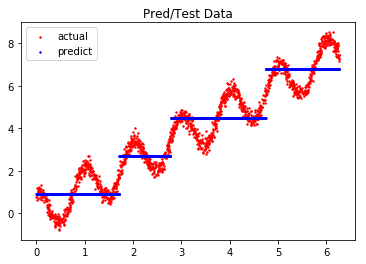

In [327]:
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(x_train,y_train)

y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

tree_mse_test

0.13576838445393843

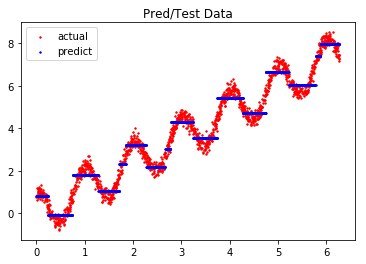

In [326]:
tree = DecisionTreeRegressor(max_depth = 4)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

tree_mse_test

0.05831044771852547

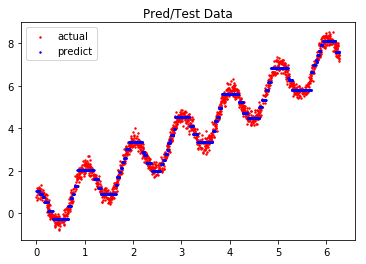

In [328]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()


tree_mse_test

0.05831044771852547

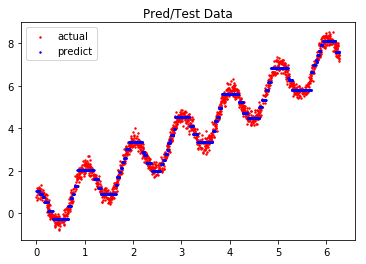

In [329]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

tree_mse_test

0.051432936058732774

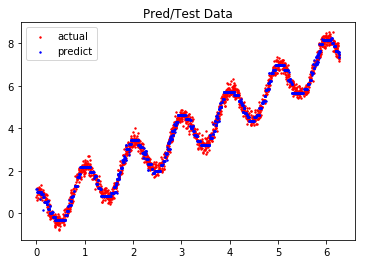

In [330]:
tree = DecisionTreeRegressor(max_depth = 8)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

tree_mse_test

0.059656326003241555

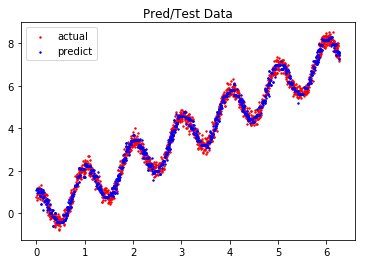

In [331]:
tree = DecisionTreeRegressor(max_depth = 10)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()


tree_mse_test

0.06845269974233656

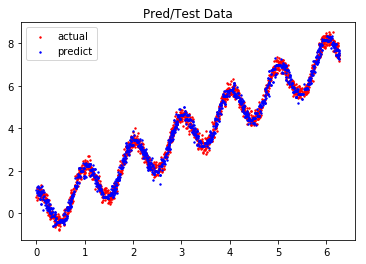

In [332]:
tree = DecisionTreeRegressor(max_depth = 12)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()


tree_mse_test

0.07262549412505968

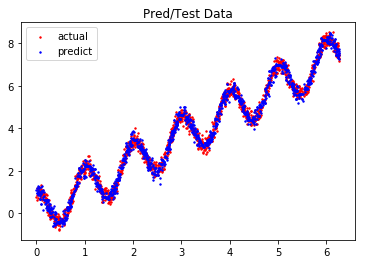

In [333]:
tree = DecisionTreeRegressor(max_depth = 14)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()


tree_mse_test

0.07572746790221369

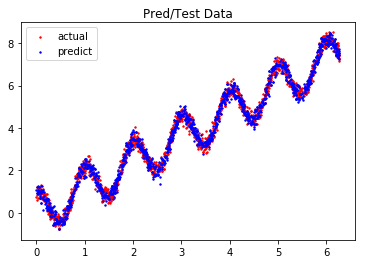

In [334]:
tree = DecisionTreeRegressor(max_depth = 16)
tree.fit(x_train,y_train)


y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()

tree_mse_test

## Part 3: Partition the data, treating `x` as time, and respecting time. 

### Re-partition the data into train/test where the test set comes AFTER the train set
### Plot the data again, putting a vertical line separating the train and test data

In [335]:
# your code here for 60/40 train/test split that respects time
x_train, x_test, y_train, y_test = train_test_split(x_vals,y_vals,test_size=0.4,shuffle = False)
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)

assert x_train.max() < x_test.min(), 'something has gone wrong splitting the data'
x_test

array([[3.76991118],
       [3.77144554],
       [3.7729799 ],
       ...,
       [6.2801166 ],
       [6.28165095],
       [6.28318531]])

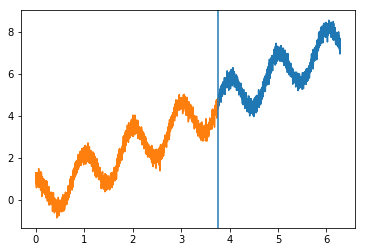

In [336]:
# plotting code here
plt1 = pd.Series(y_test, index=x_test).plot()
plt2 = pd.Series(y_train, index=x_train).plot(ax = plt1)
plt2.axvline(x = x_train.max())

## Part 4: Evaluate some estimators
We will again use test set MSE as a metric

 - ### For a bunch of different estimators, 
   - evaluate the test set MSE
   - plot both `y_test` and the predicted value for `x_test` as a function of `x_test`, in different colors
 - ### Use 
   - decision trees of depths 2, 4, 6, 8, 10, 12, 14, 16
   - linear regression
 - ### Additionally, 
   - calculate and print the MSE for a constant guess based on the train set
   - calculate and print the MSE for a constant guess based on the test set
   - __THIS ONE IS NEW__: calculate and print the MSE for guessing the previous (1-step lag) in the test set


(0.654716399396206,
 2.1638929044388404,
 19.507622604263922,
 0.07684168527319887)

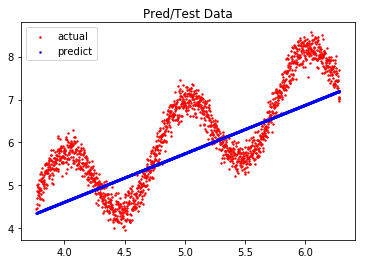

In [342]:
# your code here
# other than the time-lag problem, this should be identical code (not results) as part 2
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)
reg_mse_test = mean_squared_error(y_test, y_pred)

plt.scatter(x_test, y_test, label='actual', c='r', s=2)
plt.scatter(x_test, y_pred, label='predict', c='b', s=2)
plt.title('Pred/Test Data')
plt.legend()


const_guess = x_train.mean()
y_pred_const = [const_guess for i in range(len(y_test))]
y_train_const = [const_guess for i in range(len(y_train))]
reg_mse_test_const = mean_squared_error(y_train, y_train_const)
reg_mse_train_const = mean_squared_error(y_test,y_pred_const)
lag_1_test = np.roll(y_test,1)
mse_lag = mean_squared_error(y_test[1:],lag_1_test[1:])

reg_mse_test,reg_mse_test_const,reg_mse_train_const,mse_lag

0.654716399396206

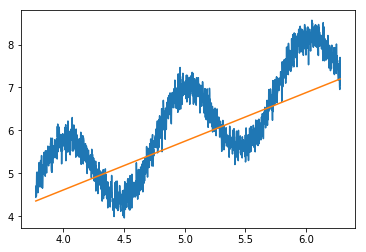

In [343]:
reg.fit(x_train_lag, y_train_lag)
y_pred_lag = reg.predict(x_test_lag)

plt1 = pd.Series(y_test_lag, index=x_test_lag).plot()
pd.Series(y_pred_lag, index=x_test_lag).plot(ax = plt1)

reg_mse_lag_test = mean_squared_error(y_test_lag, y_pred_lag)

#MSE of test,train,1_time_lag
reg_mse_test

6.20371678176338

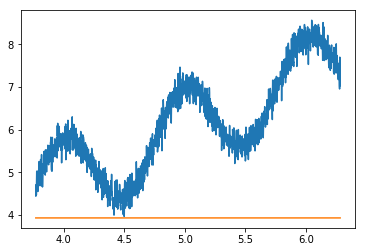

In [344]:
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)


tree_mse_test

5.046559595217041

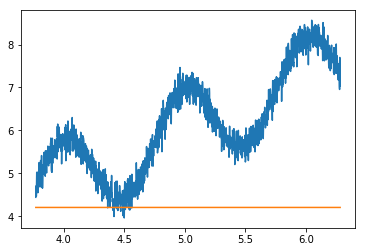

In [345]:
tree = DecisionTreeRegressor(max_depth = 4)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)

tree_mse_test

4.011244089698786

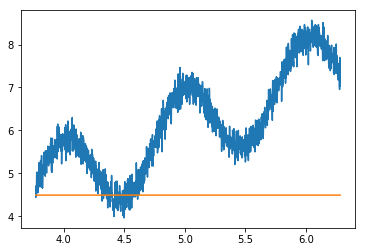

In [347]:
tree = DecisionTreeRegressor(max_depth = 6)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)

tree_mse_test

4.2218154623438435

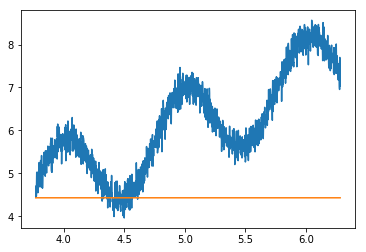

In [348]:
tree = DecisionTreeRegressor(max_depth = 8)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)



tree_mse_test

4.527760305568188

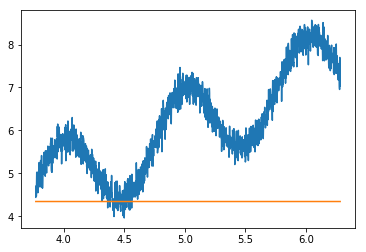

In [349]:
tree = DecisionTreeRegressor(max_depth = 10)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)



tree_mse_test

4.527760305568188

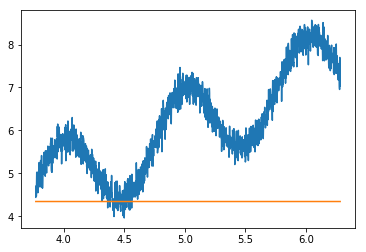

In [350]:
tree = DecisionTreeRegressor(max_depth = 12)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)



tree_mse_test

4.527760305568188

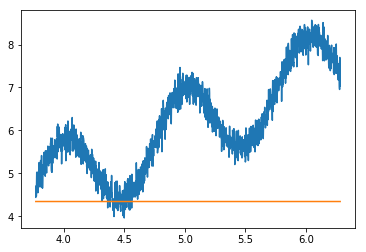

In [351]:
tree = DecisionTreeRegressor(max_depth = 14)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)


tree_mse_test

4.527760305568188

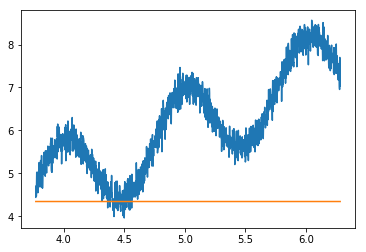

In [352]:
tree = DecisionTreeRegressor(max_depth = 16)
tree.fit(x_train,y_train)

#mse of test
y_pred = tree.predict(x_test)
tree_mse_test = mean_squared_error(y_test, y_pred)

plt1 = pd.Series(y_test, index=x_test).plot()
pd.Series(y_pred, index=x_test).plot(ax = plt1)


tree_mse_test

## Part 5: Comment on the results
What estimators do best in each case. Why is that? 

In [12]:
# put comments here

The linear regression does a better job in the time-series data and decision tree does the better job in the shuffled data. Decision tree method is the classification method so in the shuffled data set, it could identify the threshold, and make a better decision. The linear regression is to identify the factor loading, and every prediciton will be based on the factor loadings.